<a href="https://colab.research.google.com/github/gopikrishnachaganti/llm_workshop/blob/main/realtime_api_cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Instrumentation Cookbook

This notebook provides a comprehensive guide to capturing, processing, and sending audio data to Arize.

### **NOTE**: This notebook must be run locally

For further information, please reference our documentation for tracing voice applications: https://docs.arize.com/arize/examples/trace-voice-applications

## Overview of the Workflow
1. **Audio Capture:** Record audio from a microphone using the sounddevice library.
2. **Audio Processing:** Convert the recorded audio to a suitable format (PCM16) and encode it as base64.
3. **Tracing with OpenTelemetry:** Instrument your application to trace events and associate metadata.
4. **Audio Storage:** Save audio files to a cloud storage provider of your choice and set the corresponding URLs in trace spans.
5. **Integration with OpenAI API:** Send audio data to OpenAI for real-time processing and log the results.
6. **Event Logging:** Capture and log key events during the process for debugging and analysis.

## Setup

In [ ]:
import sys

if 'google.colab' in sys.modules:
    print("THIS NOTEBOOK MUST RUN LOCALLY. Colab environments do not support the necessary audio capture libraries.")
else:
    !brew install portaudio
    !pip install -q "sounddevice==0.5.1" "numpy==2.2.1" "websockets==14.1" "aiohttp==3.11.11" "opentelemetry-exporter-otlp==1.29.0" "openinference-instrumentation-openai==0.1.18" "google-cloud-storage==2.19.0" "opentelemetry-sdk==1.29.0" "openai>=1.59.5"

In [ ]:
import sounddevice as sd
import base64
import asyncio
import json
import nest_asyncio
import aiohttp
import os
from openinference.semconv.trace import (
    SpanAttributes,
    MessageAttributes,
    ToolCallAttributes,
)
import numpy as np
import subprocess
import time
import wave
from google.cloud import storage
from opentelemetry.sdk.resources import Resource
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.grpc.trace_exporter import OTLPSpanExporter
from typing import Iterable, Optional
from opentelemetry.trace import Tracer
from openai import AsyncOpenAI
from openai.types.beta.realtime.session_update_event_param import SessionTool, Session

# Apply nest_asyncio to prevent the "event loop is running" error
nest_asyncio.apply()

In [ ]:
# Audio format and recording parameters
RATE = 24000  # Sample rate for OpenAI
CHANNELS = 1  # Mono audio
RECORD_SECONDS = 5  # Duration to record


WEATHER_TOOL: SessionTool = {
    "name": "get_weather",
    "type": "function",
    "parameters": {
        "type": "object",
        "properties": {
            "lat": {
                "type": "number",
                "description": "Latitude",
            },
            "lng": {
                "type": "number",
                "description": "Longitude",
            },
            "location": {
                "type": "string",
                "description": "Location name",
            },
        },
        "required": ["lat", "lng", "location"],
    },
}

SESSION_PARAMS: Session = {
    "model": "gpt-4o-realtime-preview-2024-10-01",
    "input_audio_transcription": {
        "model": "whisper-1",
    },
    "tools": [WEATHER_TOOL],
    "tool_choice": "auto",
    "turn_detection": None,  # type: ignore
}

## Set up Tracing

To get started with instrumentation, we just need to configure our tracer. Simply update with your Arize SPACE_ID and API_KEY.  

In [ ]:
# set openai api key env var if not set
os.environ["OPENAI_API_KEY"] = ""

ARIZE_SPACE_ID = os.environ.get("ARIZE_SPACE_ID", "")
ARIZE_API_KEY = os.environ.get("ARIZE_API_KEY", "")

PROJECT_NAME = "openai-realtime-audio"  # Set this to any name you'd like for your app

assert ARIZE_SPACE_ID, "Please set your ARIZE_SPACE_ID for logging"
assert ARIZE_API_KEY, "Please set your ARIZE_API_KEY for logging"


# Set the Space and API keys as headers for authentication
headers = f"space_id={ARIZE_SPACE_ID},api_key={ARIZE_API_KEY}"
os.environ["OTEL_EXPORTER_OTLP_TRACES_HEADERS"] = headers


# Set resource attributes for the name and version for your application
resource = Resource(
    attributes={
        "model_id": PROJECT_NAME,
        # "model_version": "1.0",  # Set this to a version number string
    }
)
endpoint = "https://otlp.arize.com/v1"
span_exporter = OTLPSpanExporter(endpoint=endpoint)
tracer_provider = trace_sdk.TracerProvider(resource=resource)
span_processor = SimpleSpanProcessor(span_exporter=span_exporter)
tracer_provider.add_span_processor(span_processor=span_processor)
trace_api.set_tracer_provider(tracer_provider=tracer_provider)

tracer = trace_api.get_tracer(__name__)

## Storage Helper Functions

To enable audio playback in the Arize UI, audio files need to be stored in a cloud storage solution, and a link to the stored file must be included in your instrumentation. This step is **optional**. If you do not wish to enable audio playback, you can skip this section.

In this example, we demonstrate how to use Google Cloud Storage (GCS) to store audio files. To specify the bucket where your audio files will be stored, specify a bucket and path or leave these as empty strings to skip storage of these audio files:

If you prefer a different storage provider, update the function accordingly. Ensure that the chosen storage solution is accessible via a URL so that Arize can retrieve the audio file. If you modify the storage logic, make sure to adjust the relevant function calls in your instrumentation code to reflect the changes.

In [ ]:
# Uncomment the following lines to test with empty bucket information
GCS_BUCKET = ""
GCS_PATH = ""

In [ ]:
def check_bucket_access(bucket_name):
    try:
        # Attempt to list the bucket's contents to verify access
        result = subprocess.run(
            ["gsutil", "ls", f"gs://{bucket_name}"],
            check=True,
            capture_output=True,
            text=True
        )
        print(f"Access to bucket '{bucket_name}' verified.")
    except subprocess.CalledProcessError as e:
        if "AccessDeniedException" in e.stderr:
            raise PermissionError(f"Access denied to bucket '{bucket_name}'. Please ensure you have the necessary permissions.")
        else:
            raise RuntimeError(f"An error occurred while accessing the bucket: {e.stderr}")

# Check if both GCS_BUCKET and GCS_PATH are non-empty
if GCS_BUCKET and GCS_PATH:
    try:
        # Execute the gcloud auth login command
        subprocess.run(["gcloud", "auth", "login"], check=True)
        print("Authentication successful.")

        # Check if the user has access to the specified bucket
        check_bucket_access(GCS_BUCKET)

    except subprocess.CalledProcessError as e:
        print(f"An error occurred during authentication: {e}")
    except PermissionError as e:
        print(e)
    except RuntimeError as e:
        print(e)
else:
    print("Bucket information is incomplete. Skipping authentication.")

# path for tmp file - default is the dir for this notebook
TMP_FILE_PATH = os.path.dirname(os.path.abspath(""))

GCS_CLIENT = storage.Client()

def save_audio_to_wav(
    audio_data: np.ndarray,
    local_file_path: str,
    sample_rate: int = RATE,
    channels: int = CHANNELS,
    sample_width: int = 2,
) -> None:
    """Saves audio data as a WAV file."""
    if not isinstance(audio_data, np.ndarray):
        raise ValueError("audio_data must be a NumPy array.")

    with wave.open(local_file_path, "wb") as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(sample_width)
        wf.setframerate(sample_rate)
        wf.writeframes(audio_data.tobytes())


def upload_to_gcs(
    local_file_path: str,
    bucket_name: str,
    destination_blob_name: str,
    make_public: bool = False,
) -> str:
    """Uploads a file to Google Cloud Storage."""
    try:
        bucket = GCS_CLIENT.bucket(bucket_name)
        blob = bucket.blob(destination_blob_name)
        blob.upload_from_filename(local_file_path)
        if make_public:
            blob.make_public()
            return blob.public_url
        else:
            return f"https://storage.cloud.google.com/{bucket_name}/{destination_blob_name}"
    except Exception as e:
        raise RuntimeError(f"Failed to upload {local_file_path} to GCS: {e}")


def process_audio_and_upload(
    prefix: str,
    pcm16_audio: np.ndarray,
) -> str:
    """Processes audio, saves as WAV, uploads to GCS, and cleans up."""
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    file_name = f"{prefix}_audio_{timestamp}.wav"

    gcs_path = (
        f"{GCS_PATH}{file_name}" if GCS_PATH and GCS_PATH[-1] == "/" else f"{GCS_PATH}/{file_name}"
    )
    local_file_path = (
        f"{TMP_FILE_PATH}{file_name}"
        if TMP_FILE_PATH[-1] == "/"
        else f"{TMP_FILE_PATH}/{file_name}"
    )

    save_audio_to_wav(pcm16_audio, local_file_path)
    gcs_url = ""
    if GCS_PATH:
        gcs_url = upload_to_gcs(local_file_path, GCS_BUCKET, gcs_path)

    if os.path.exists(local_file_path):
        os.remove(local_file_path)

    return gcs_url

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=Vzn1ogEQBCVxvTECkHldczTBmPe2vk&access_type=offline&code_challenge=nWtgJ_LISZ66UtsrDAekQNmG6hAZpcR8cG7G51HVCT4&code_challenge_method=S256


You are now logged in as [sdelucia@arize.com].
Your current project is [arize-testing].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


Authentication successful.
Access to bucket 'jz999' verified.


/Users/sallyanndelucia/miniconda3/envs/audio_env/lib/python3.9/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/sallyanndelucia/miniconda3/envs/audio_env/lib/python3.9/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Audio processing helper functions

These functions will help us capture and process audio to use in our realtime voice application.

In [ ]:
def capture_audio(record_seconds: int) -> np.ndarray:
    """Captures audio using sounddevice."""
    print("Recording...")
    audio_data = sd.rec(
        int(record_seconds * RATE),
        samplerate=RATE,
        channels=CHANNELS,
        dtype="float32",
    )
    sd.wait()
    print("Recording finished.")
    return audio_data.flatten()


def float_to_pcm16(float32_array):
    """Converts float32 audio to PCM16."""
    int16_array = np.clip(float32_array, -1, 1) * 32767
    return int16_array.astype(np.int16)


def pcm16_to_base64(pcm16_array):
    """Converts PCM16 audio to base64-encoded string."""
    return base64.b64encode(pcm16_array.tobytes()).decode("utf-8")


def base64_to_pcm16(base64_string):
    """Converts a base64-encoded string back to a PCM16 NumPy array."""
    # Decode Base64 string to bytes
    pcm_bytes = base64.b64decode(base64_string)
    # Convert bytes to a NumPy array of int16
    return np.frombuffer(pcm_bytes, dtype=np.int16)

## Instrumentation helper functions

In [ ]:
def set_tools_on_span(tools: Iterable[SessionTool], _span):
    """
    Process tools in the session update event and set their attributes.
    """
    for i, tool in enumerate(tools):
        tool_name = tool.get("name", f"tool_{i}")
        tool_type = tool.get("type", "unknown")
        tool_description = tool.get("description", "")
        tool_parameters = tool.get("parameters", {})

        # Create a JSON schema-like attribute for the tool
        tool_json_schema = json.dumps(tool_parameters)

        # Set tool attributes in the span
        _span.set_attribute(f"llm.tools.{i}.tool.name", tool_name)
        _span.set_attribute(f"llm.tools.{i}.tool.type", tool_type)
        _span.set_attribute(f"llm.tools.{i}.tool.description", tool_description)
        _span.set_attribute(f"llm.tools.{i}.tool.json_schema", tool_json_schema)
        _span.set_attribute(
            f"{SpanAttributes.LLM_OUTPUT_MESSAGES}.0.{MessageAttributes.MESSAGE_TOOL_CALLS}.0.{ToolCallAttributes.TOOL_CALL_FUNCTION_ARGUMENTS_JSON}",
            tool_json_schema,
        )
        _span.set_attribute(
            f"{SpanAttributes.LLM_OUTPUT_MESSAGES}.0.{MessageAttributes.MESSAGE_TOOL_CALLS}.0.{ToolCallAttributes.TOOL_CALL_FUNCTION_NAME}",
            tool_name,
        )

## Let's add a tool

Our application is going to be able to tell the weather using the `get_weather` tool. This tool users the a weather api to get the current weather conditions based on a lat and long

In [ ]:
async def get_weather(lat, lng, location):
    """Fetches weather data from the Open Meteo API."""
    params = {
        "latitude": lat,
        "longitude": lng,
        "current_weather": "true",
    }  # Changed to string
    API_URL = "https://api.open-meteo.com/v1/forecast"
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(API_URL, params=params) as response:
                if response.status == 200:
                    weather_data = await response.json()
                    current_weather = weather_data.get("current_weather", {})
                    return {
                        "temperature": current_weather.get("temperature"),
                        "wind_speed": current_weather.get("windspeed"),
                        "location": location,
                    }
                else:
                    return {"error": "Failed to fetch weather data."}
    except Exception as e:
        return {"error": str(e)}

## Send Audio and Log Spans

The below function holds majority of our application and tracing code. We will:


1.   Set up the websocket to use the OpenAI realtime application
2.   Update our session with our tool and and enable transcription
3.   Collect audio
4.   Process audio + save to gcs
5.   Send audio to OpenAI
6.   Listen for events and set spans



In [ ]:
class AudioServer:
    def __init__(self, session_params: Session, tracer: Tracer):
        self.session_params = session_params
        self.tracer = tracer
        self.session = None
        self.response_audio_b64 = ""
        self.response_transcript = ""
        self.client = AsyncOpenAI()
        self.weather_data = None
        self.previous_event_type = ""
        self.response_in_flight = False
        self.transcript_in_flight = bool(
            session_params.get("input_audio_transcription", {}).get("model")
        )
        self.connection = None

    async def create_response(self):
        if not self.connection:
            return

        self.response_in_flight = True
        return await self.connection.response.create()

    async def send_audio_and_log_events(self, audio_data: np.ndarray) -> None:
        async with self.client.beta.realtime.connect(
            model="gpt-4o-realtime-preview-2024-10-01"
        ) as conn:
            self.connection = conn

            await conn.session.update(session=self.session_params)
            print("Client: session.update")

            # Start the parent span for the "realtime.session"
            with self.tracer.start_as_current_span(
                "session established",
                attributes={SpanAttributes.OPENINFERENCE_SPAN_KIND: "CHAIN"},
            ) as parent_span:
                pcm16_audio = float_to_pcm16(audio_data)
                base64_audio_data = pcm16_to_base64(pcm16_audio)

                self.input_audio_url = process_audio_and_upload(prefix="input", pcm16_audio=pcm16_audio)
                print("Saving input audio to ", self.input_audio_url)

                parent_span.set_attribute("input.audio.url", self.input_audio_url)

                # First upload the audio
                await self.connection.input_audio_buffer.append(audio=base64_audio_data)
                print("Client: input_audio_buffer.append")
                # Tell OAI audio is done
                await self.connection.input_audio_buffer.commit()
                print("Client: input_audio_buffer.commit")

                # Now ask for a response - which actually runs the model
                await self.create_response()
                print("Client: response.create")

                with self.tracer.start_as_current_span(
                    "conversation.item.created",
                    attributes={
                        SpanAttributes.OPENINFERENCE_SPAN_KIND: "LLM",
                        "input.audio.url": self.input_audio_url,
                    },
                ) as input_audio_span:

                    async for event in conn:
                        if "input_audio_buffer" in event.type:
                            print(f"Server: {event.type}")
                            print(json.dumps(event.to_dict(), indent=4))

                        elif "delta" in event.type:
                            if event.type == self.previous_event_type:
                                print(".", end="")
                            else:
                                print(f"\nServer: {event.type}", end="")

                        elif "delta" in self.previous_event_type:
                            print(f"\nServer: {event.type}")
                        else:
                            print(f"Server: {event.type}")

                        self.previous_event_type = event.type

                        if event.type == "error":
                            print(event)
                        if event.type == "session.created":
                            self.session = event.session
                            assert event.session.id is not None
                            continue

                        if event.type == "session.updated":
                            self.session = event.session
                            set_tools_on_span([WEATHER_TOOL], input_audio_span)

                            parent_span.set_attribute(
                                "attributes.llm.input_messages.0.message.role", "system"
                            )
                            if event.session.instructions:
                                parent_span.set_attribute(
                                    "attributes.llm.input_messages.0.message.content",
                                    event.session.instructions,
                                )
                            if event.session.id:
                                parent_span.set_attribute(
                                    SpanAttributes.SESSION_ID, event.session.id
                                )

                            parent_span.set_attribute(
                                "metadata.input_audio_transcription", "enabled"
                            )
                            continue

                        if event.type == "response.audio.delta":
                            self.response_audio_b64 += event.delta
                            continue

                        if event.type == "response.audio_transcript.done":
                            self.response_transcript = event.transcript
                            continue

                        if (
                            event.type
                            == "conversation.item.input_audio_transcription.completed"
                        ):
                            parent_span.set_attribute(
                                SpanAttributes.INPUT_VALUE, event.transcript
                            )
                            parent_span.set_attribute(
                                "input.audio.transcript", event.transcript
                            )

                            input_audio_span.set_attribute(
                                "input.audio.transcript", event.transcript
                            )
                            self.transcript_in_flight = False
                            # If transcript comes after response is done, then close conn
                            if not self.response_in_flight:
                                return

                            continue

                        if event.type == "response.done":
                            self.response_in_flight = False
                            for item in event.response.output or []:
                                if item.type == "function_call":
                                    self.weather_data = await self.handle_tool_call(
                                        item.arguments
                                    )
                                    input_audio_span.set_attribute(
                                        SpanAttributes.OUTPUT_VALUE,
                                       f"get_weather{item.arguments}",
                                    )

                                    if self.weather_data:
                                        await self.connection.conversation.item.create(
                                            item={
                                                "call_id": str(item.call_id),
                                                "type": "function_call_output",
                                                "output": str(self.weather_data),
                                            },
                                        )
                                        print(
                                            "Client: conversation.item.create: ",
                                            str(self.weather_data),
                                        )
                                        await self.create_response()
                                        print("Client: response.create")

                                    continue

                                if item.type == "message":
                                    # Handle standard message response after weather data is sent
                                    with self.tracer.start_as_current_span(
                                        "Response",
                                        attributes={
                                            SpanAttributes.OPENINFERENCE_SPAN_KIND: "LLM",
                                        }
                                    ) as response_span:
                                        if self.weather_data:
                                            response_span.set_attribute(
                                                SpanAttributes.INPUT_VALUE,
                                                f"weather_data={self.weather_data}",
                                            )

                                        for content in item.content or []:
                                            if (
                                                content.type == "audio"
                                                and content.transcript
                                            ):
                                                print("Transcript: ", content.transcript)
                                                parent_span.set_attribute(
                                                    SpanAttributes.OUTPUT_VALUE,
                                                    content.transcript,
                                                )
                                                parent_span.set_attribute(
                                                    "output.audio.transcript",
                                                    content.transcript,
                                                )
                                                response_span.set_attribute(
                                                    "output.audio.transcript",
                                                    content.transcript,
                                                )


                                        output_audio = base64_to_pcm16(
                                            self.response_audio_b64
                                        )
                                        self.response_audio_b64 = ""


                                        # Generate the audio URL for playback in the Arize UI.
                                        # NOTE: The process_audio_and_upload function is defined above.
                                        # If you skipped the storage setup or are using a different storage solution,
                                        # make sure to update this logic to match your storage implementation.
                                        # Without a valid URL, audio playback will not be available in the Arize UI.

                                        try:
                                            url = process_audio_and_upload("output", output_audio)
                                            print("Output audio URL:", url)
                                        except NameError as e:
                                            # Handle case where the function isn't defined or storage is skipped
                                            url = None
                                            print(
                                                "WARNING: process_audio_and_upload function is not defined or skipped. "
                                                "Audio playback will not be available in the Arize UI. "
                                                "Ensure the function is implemented and update this logic accordingly."
                                            )

                                        response_span.set_attribute("output.audio.url", url)
                                        parent_span.set_attribute("output.audio.url", url)


                                        # exit the function - unless we're waiting for a transcript
                                        if not self.transcript_in_flight:
                                            return

    async def handle_tool_call(self, arguments_str: Optional[str]):
        with self.tracer.start_as_current_span("Tool- GetWeather") as tool_span:
            tool_span.set_attribute(
                SpanAttributes.OPENINFERENCE_SPAN_KIND,
                "TOOL",
            )

            # Extract weather arguments (lat, lng, location)
            if arguments_str:
                tool_span.set_attribute(
                    SpanAttributes.INPUT_VALUE,
                    arguments_str,
                )

                arguments = json.loads(arguments_str)

                lat = arguments.get("lat")
                lng = arguments.get("lng")
                location = arguments.get("location")

                if lat and lng and location:
                    # Call the weather API
                    weather_data = await get_weather(lat, lng, location)

                    tool_span.set_attribute(
                        SpanAttributes.OUTPUT_VALUE,
                        str(weather_data),
                    )
                    return weather_data

            return None

In [ ]:
RECORD_SECONDS = 5


def capture_and_send_audio(session_params, tracer):
    app = AudioServer(session_params, tracer)

    audio_data = capture_audio(record_seconds=RECORD_SECONDS)
    asyncio.get_event_loop().run_until_complete(
        app.send_audio_and_log_events(audio_data)
    )

Now we're all set to start using our application! Here are a few tests you can practice recording:

1) Look up the weather for a state without specifying the city:
    `"Whats the weather in Connecticut"`

In [ ]:
# Call this function to start the audio capture and event sending
capture_and_send_audio(SESSION_PARAMS, tracer)

Recording...
Recording finished.
Client: session.update
Saving input audio to  https://storage.cloud.google.com/jz999/sallyann/audio/input_audio_20250109_210733.wav
Client: input_audio_buffer.append
Client: input_audio_buffer.commit
Client: response.create
Server: session.created
Server: session.updated
Server: input_audio_buffer.committed
{
    "event_id": "event_Ao0b0QDJfSDPT4GJcTU4u",
    "item_id": "item_Ao0b0YO0qSt7wOJ3GBQYy",
    "previous_item_id": null,
    "type": "input_audio_buffer.committed"
}
Server: conversation.item.created
Server: response.created
Server: rate_limits.updated
Server: response.output_item.added
Server: conversation.item.created

Server: response.function_call_arguments.delta...................
Server: response.function_call_arguments.done
Server: response.output_item.done
Server: response.done
Client: conversation.item.create:  {'temperature': -3.1, 'wind_speed': 24.4, 'location': 'New York'}
Client: response.create
Server: conversation.item.input_audio_t

2) Look up the weather for a state and specify the city:
    `"Whats the weather in Stamford, Connecticut"`

In [ ]:
# Call this function to start the audio capture and event sending
capture_and_send_audio(SESSION_PARAMS, tracer)

Recording...
Recording finished.
Client: session.update
Saving input audio to  https://storage.cloud.google.com/jz999/sallyann/audio/input_audio_20250109_210951.wav
Client: input_audio_buffer.append
Client: input_audio_buffer.commit
Client: response.create
Server: session.created
Server: session.updated
Server: input_audio_buffer.committed
{
    "event_id": "event_Ao0dEEfnlCE1Oaax6tzu6",
    "item_id": "item_Ao0dEvz4gsPMyZgby88QD",
    "previous_item_id": null,
    "type": "input_audio_buffer.committed"
}
Server: conversation.item.created
Server: response.created
Server: rate_limits.updated
Server: response.output_item.added
Server: conversation.item.created

Server: response.function_call_arguments.delta...................
Server: response.function_call_arguments.done
Server: response.output_item.done
Server: response.done
Client: conversation.item.create:  {'temperature': -1.6, 'wind_speed': 22.8, 'location': 'Philadelphia'}
Client: response.create
Server: conversation.item.input_aud

Once you send a request head to Arize to checkout the trace!

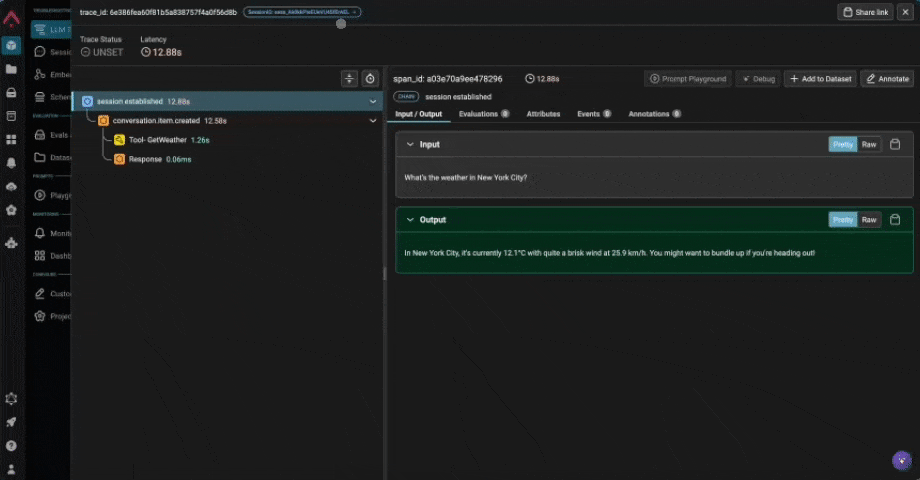